# Trasfer learning model

In [1]:
import numpy as np
import pathlib
import PIL
import os
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import warnings

warnings.filterwarnings('ignore')

## Dataset

In [2]:
dataset_path = os.path.join('../Brain Tumor Data Set')
dataset = tf.keras.utils.image_dataset_from_directory(dataset_path)

dataset

Found 4600 files belonging to 2 classes.


<BatchDataset shapes: ((None, 256, 256, 3), (None,)), types: (tf.float32, tf.int32)>

In [3]:
class_names = np.array(dataset.class_names)
print(class_names)

['Brain Tumor' 'Healthy']


### Train - test split

In [4]:
ds_train = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset='training',
    seed=404,
    batch_size=64
)

Found 4600 files belonging to 2 classes.
Using 3680 files for training.


In [5]:
ds_val = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset='validation',
    seed=404,
    batch_size=64
)

Found 4600 files belonging to 2 classes.
Using 920 files for validation.


In [6]:
for image_batch, labels_batch in ds_train:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(64, 256, 256, 3)
(64,)


## Mobilenet_v2 - simple model

In [7]:
input_shape = (224, 224, 3)

In [8]:
resizer = lambda x, y: (tf.image.resize(x, input_shape[:2]), y)

ds_train_reshaped = ds_train.map(resizer)
ds_val_reshaped = ds_val.map(resizer)

In [9]:
for image_batch, labels_batch in ds_train_reshaped:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(64, 224, 224, 3)
(64,)


In [10]:
base_model = keras.applications.mobilenet_v2.MobileNetV2(
    weights='imagenet',
    input_shape=input_shape,
    include_top=False
)

base_model.trainable = False

model = tf.keras.Sequential(
    [
        keras.layers.Input(input_shape, dtype=tf.float32),
        base_model,
        keras.layers.GlobalAveragePooling2D(),
        keras.layers.Dense(1)
    ],
    name='mobilenet_simple'
)

model.summary()

Model: "mobilenet_simple"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [11]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

In [12]:
epochs = 60
patience = 2

In [13]:
history = model.fit(
    ds_train_reshaped,
    epochs=epochs,
    validation_data=ds_val_reshaped,
    callbacks=[keras.callbacks.EarlyStopping(patience=patience)]
)

Epoch 1/60
58/58 [==============================] - 74s 1s/step - loss: 0.5730 - binary_accuracy: 0.6595 - val_loss: 0.4499 - val_binary_accuracy: 0.7152
Epoch 2/60
58/58 [==============================] - 70s 1s/step - loss: 0.3848 - binary_accuracy: 0.8166 - val_loss: 0.3593 - val_binary_accuracy: 0.8239
Epoch 3/60
58/58 [==============================] - 72s 1s/step - loss: 0.3299 - binary_accuracy: 0.8554 - val_loss: 0.3254 - val_binary_accuracy: 0.8511
Epoch 4/60
58/58 [==============================] - 71s 1s/step - loss: 0.3023 - binary_accuracy: 0.8715 - val_loss: 0.3040 - val_binary_accuracy: 0.8707
Epoch 5/60
58/58 [==============================] - 70s 1s/step - loss: 0.2836 - binary_accuracy: 0.8818 - val_loss: 0.2923 - val_binary_accuracy: 0.8696
Epoch 6/60
58/58 [==============================] - 70s 1s/step - loss: 0.2716 - binary_accuracy: 0.8908 - val_loss: 0.2791 - val_binary_accuracy: 0.8826
Epoch 7/60
58/58 [==============================] - 71s 1s/step - loss: 0.25

In [14]:
history.history.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

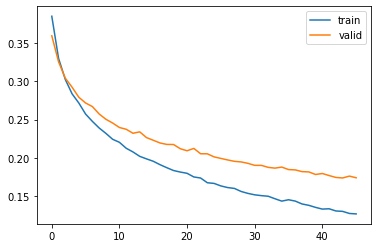

In [15]:
plt.plot(history.history['loss'][1:])
plt.plot(history.history['val_loss'][1:])
plt.legend(['train', 'valid'])
plt.show();

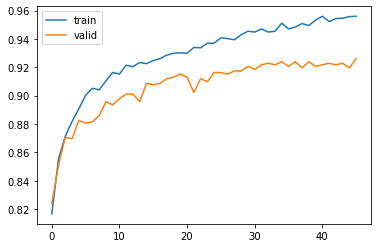

In [16]:
plt.plot(history.history['binary_accuracy'][1:])
plt.plot(history.history['val_binary_accuracy'][1:])
plt.legend(['train', 'valid'])
plt.show();

### Classification accuracy

In [17]:
test_batch = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset='validation',
    seed=404,
    batch_size=920
)

test_batch_resized = test_batch.map(resizer)

Found 4600 files belonging to 2 classes.
Using 920 files for validation.


In [18]:
x_test, y_test = list(tfds.as_numpy(test_batch_resized))[0]
y_pred = model.predict(x_test)
sum((y_pred[:, 0] > 0) == y_test) / len(y_test)

0.9304347826086956

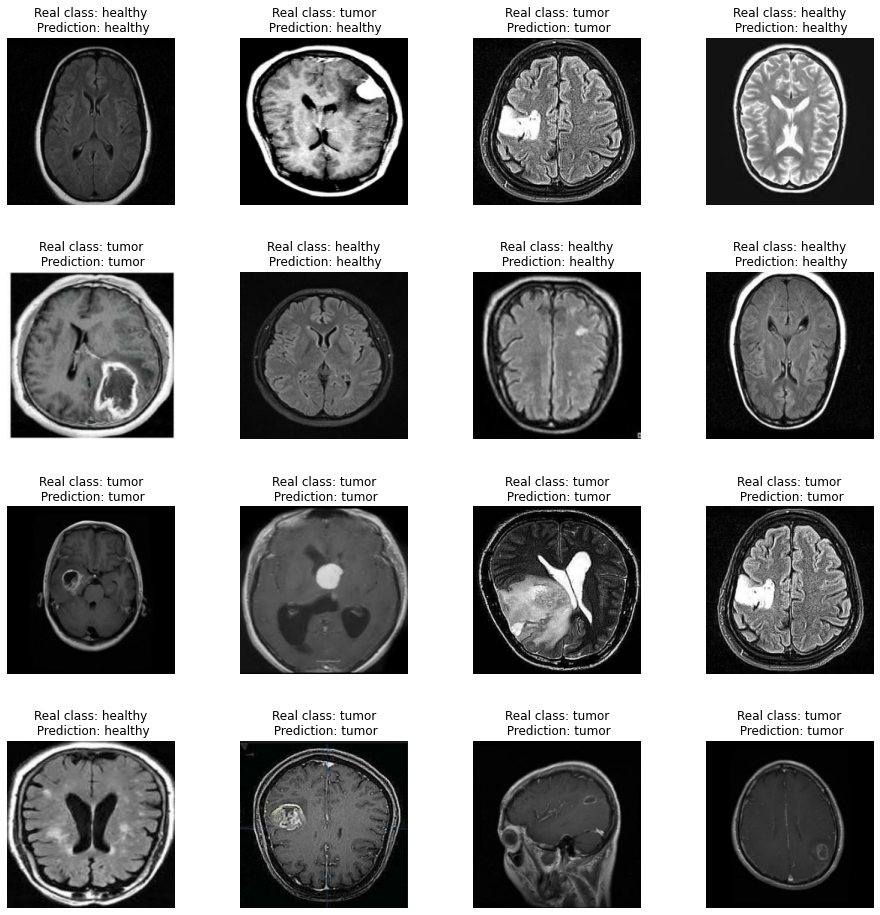

In [19]:
plt.figure(figsize=(16, 16))
plt.subplots_adjust(hspace=0.4, wspace=.2)

for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(x_test[i].astype('int32'))
    
    real_y = 'healthy' if y_test[i] == 1 else 'tumor'
    pred_y = 'healthy' if y_pred[i] > 0 else 'tumor'
    
    plt.title(f'Real class: {real_y}\n Prediction: {pred_y}')
    plt.axis('off')
plt.show();

In [20]:
y_pred_binary = [1 if y > 0 else 0 for y in y_pred]

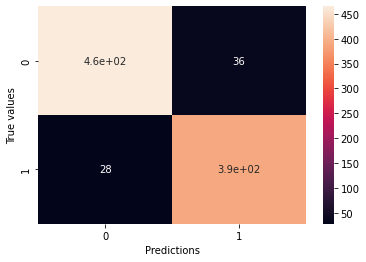

In [21]:
cf = tf.math.confusion_matrix(y_test, y_pred_binary, dtype=tf.dtypes.int32)
sns.heatmap(cf, annot=True)
plt.xlabel('Predictions')
plt.ylabel('True values')
plt.show();

In [22]:
print(classification_report(y_test, y_pred_binary, target_names=class_names))

              precision    recall  f1-score   support

 Brain Tumor       0.94      0.93      0.94       501
     Healthy       0.92      0.93      0.92       419

    accuracy                           0.93       920
   macro avg       0.93      0.93      0.93       920
weighted avg       0.93      0.93      0.93       920



## Single prediction

In [23]:
data_dir = pathlib.Path(dataset_path)

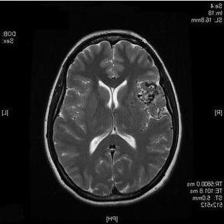

In [24]:
healthy = list(data_dir.glob('Healthy/*'))
img = PIL.Image.open(str(healthy[np.random.randint(0, 500)])).resize((224, 224))
img

In [25]:
to_predict = np.array(img)
to_predict.shape

(224, 224, 3)

In [26]:
prediction = model.predict(to_predict[np.newaxis, ...])
result = 'healthy' if prediction > 0 else 'tumor'
result

'healthy'

In [27]:
%time model.predict(to_predict[np.newaxis, ...])

Wall time: 54 ms


array([[1.5996962]], dtype=float32)

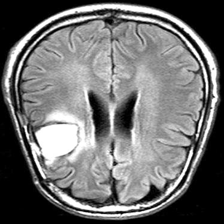

In [28]:
tumors = list(data_dir.glob('Brain Tumor/*'))
img = PIL.Image.open(str(tumors[np.random.randint(0, 500)])).resize((224, 224))
img

In [29]:
to_predict = np.array(img)
to_predict.shape

(224, 224, 3)

In [30]:
prediction = model.predict(to_predict[np.newaxis, ...])
result = 'healthy' if prediction > 0 else 'tumor'
result

'tumor'

In [31]:
%time model.predict(to_predict[np.newaxis, ...])

Wall time: 52 ms


array([[-2.8030405]], dtype=float32)

## Saving and loading model

In [32]:
model.save('model_tl.h5')

In [33]:
from keras.models import load_model

model_from_file = load_model('model_tl.h5')
model_from_file.summary()

Model: "mobilenet_simple"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [34]:
model.save_weights('weights/model_tl')

In [35]:
model_from_file.load_weights('weights/model_tl')

In [36]:
y_pred_from_file = model_from_file.predict(x_test)
sum((y_pred_from_file[:, 0] > 0) == y_test) / len(y_test)

0.9304347826086956

In [37]:
y_pred_from_file_binary = [1 if y > 0 else 0 for y in y_pred_from_file]

print(classification_report(y_test, y_pred_from_file_binary))

              precision    recall  f1-score   support

           0       0.94      0.93      0.94       501
           1       0.92      0.93      0.92       419

    accuracy                           0.93       920
   macro avg       0.93      0.93      0.93       920
weighted avg       0.93      0.93      0.93       920



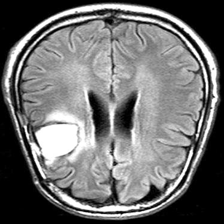

In [38]:
img

In [39]:
prediction = model_from_file.predict(to_predict[np.newaxis, ...])
result = 'healthy' if prediction > 0 else 'tumor'
result

'tumor'

## Script testing

In [40]:
import sys
sys.path.append('..')

In [41]:
import prediction_for_app as pfa

In [42]:
model_from_script = pfa.DLModel('model_tl.h5', 'weights/model_tl', (224, 224))

In [43]:
model_from_script.predict_for_user_input(tumors[np.random.randint(0, 500)])

'Brain tumor'

In [44]:
model_from_script.predict_for_user_input(healthy[np.random.randint(0, 500)])

'Healthy'